In [73]:
import pandas as pd
import numpy as np
import implicit
import plotly.express as px
from pandas.core.reshape.merge import merge
from plotly.subplots import make_subplots
import plotly.graph_objects as go#scatter charts
import plotly.figure_factory as ff#creates unique chart types
from plotly.colors import hex_to_rgb#color converter
from sklearn.feature_extraction.text import CountVectorizer#transform text to vector
from sklearn.metrics.pairwise import cosine_similarity#cosine simiarity package
from sklearn.neighbors import NearestNeighbors#knn package
from sklearn.preprocessing import LabelEncoder #converting lable to numerical
from tqdm import tqdm # A fancy library used to progress the bars

c:\Users\elman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [75]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [76]:
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [77]:
data = movies.merge (credits,on = 'title')#new data set after merging

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [79]:
data.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [80]:
#geners
#title
#keywords
#cast
#director
#overview
data = data[['movie_id','title','overview','genres','keywords','cast','crew','release_date','vote_average','vote_count','popularity']]

In [81]:

data.info

<bound method DataFrame.info of       movie_id                                     title  \
0        19995                                    Avatar   
1          285  Pirates of the Caribbean: At World's End   
2       206647                                   Spectre   
3        49026                     The Dark Knight Rises   
4        49529                               John Carter   
...        ...                                       ...   
4804      9367                               El Mariachi   
4805     72766                                 Newlyweds   
4806    231617                 Signed, Sealed, Delivered   
4807    126186                          Shanghai Calling   
4808     25975                         My Date with Drew   

                                               overview  \
0     In the 22nd century, a paraplegic Marine is di...   
1     Captain Barbossa, long believed to be dead, ha...   
2     A cryptic message from Bond’s past sends him o...   
3     Follo

In [82]:
data.head(1)

,movie_id,title,overview,genres,keywords,cast,crew,release_date,vote_average,vote_count,popularity
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,7.2,11800,150.437577


In [83]:

data.isnull().sum()

movie_id        0
title           0
overview        3
genres          0
keywords        0
cast            0
crew            0
release_date    1
vote_average    0
vote_count      0
popularity      0
dtype: int64

In [84]:
data.dropna(inplace=True)

In [85]:
len(data)

4805

In [86]:
data.duplicated().sum()

0

In [87]:
data.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [88]:
new_types={'title': str,'overview': str,'release_date': 'datetime64[ns]'}
for col in new_types.keys():
    data[col]=data[col].astype(new_types[col])


In [89]:
def get_uniques(data,col):
    out=set([val.strip().lower() for val in ','.join(data[col].unique()).split(',')])
    try:
        out.remove('')
    except:
        return list(out)
    return list(out)

In [90]:
genres = get_uniques(data,'genres')
keywords = get_uniques(data,'keywords')
cast = get_uniques(data,'cast')
crew = get_uniques(data,'crew')

In [91]:
from tqdm import tqdm
def get_counts(data, col, categories):
    categ = {(category): None for category in categories}
    for category in tqdm(categories):
        val=0
        for index in data.index:
            if category in data.at[index,col].lower():
                val+=1
        categ[category]=val
    return categ

In [92]:
import plotly.express as px
base_counts = get_counts(data, 'genres', genres)
base_counts = pd.DataFrame(index=base_counts.keys(),
                           data=base_counts.values(),
                           columns=['Counts'])
base_counts.sort_values(by='Counts', inplace=True)
# Plot the chart which shows top genres and separate by color where genre<1000
colors=['#abaeab' if i<1000 else '#A0E045' for i in  base_counts.Counts]
fig = px.bar(x=base_counts.index,
             y=base_counts['Counts'],
             title='Most Popular Genre',color_discrete_sequence=colors,color=base_counts.index)
fig.show()

100%|██████████| 81/81 [00:01<00:00, 47.08it/s]
c:\Users\elman\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [93]:
import plotly.express as px

def plot_value_counts_bar(data, col):
    vc = pd.DataFrame(data[col].value_counts())
    vc['year'] = vc.index
    fig = px.bar(vc, x='year', y='count', color='year', title=col)
    fig.update_layout()
    return fig

data['cat'] = data.release_date.dt.year
plot_value_counts_bar(data, 'cat')


In [94]:

#change the formate into list
def convert(obj):
  l=[]
  for i in ast.literal_eval(obj) :
      l.append(i['name'])
  return l

In [95]:

import ast
ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [96]:
data['genres']=data['genres'].apply(convert)

In [97]:

data['keywords'] = data['keywords'].apply(convert)

In [98]:


data.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,vote_average,vote_count,popularity,cat
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,7.2,11800,150.437577,2009
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007-05-19,6.9,4500,139.082615,2007
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015-10-26,6.3,4466,107.376788,2015
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012-07-16,7.6,9106,112.312950,2012
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012-03-07,6.1,2124,43.926995,2012


In [99]:
#to take cast of top 3
def convert3(obj):
  l=[]
  counter = 0
  for i in ast.literal_eval(obj):
    if counter!= 3:
      l.append(i['name'])
      counter+=1
    else:
         break
  return l

In [100]:
data['cast']=data['cast'].apply(convert3)

In [101]:

data.head()


,movie_id,title,overview,genres,keywords,cast,crew,release_date,vote_average,vote_count,popularity,cat
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,7.2,11800,150.437577,2009
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007-05-19,6.9,4500,139.082615,2007
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015-10-26,6.3,4466,107.376788,2015
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012-07-16,7.6,9106,112.312950,2012
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012-03-07,6.1,2124,43.926995,2012


In [102]:
data['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [103]:
#fetching direction from jobs
def fetch_director (obj):
  l=[]
  for i in ast.literal_eval(obj) :
    if i['job'] == 'Director':
      l.append(i['name'])
      break
  return l

In [104]:

data['crew'] = data['crew'].apply(fetch_director)

In [105]:
data.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,vote_average,vote_count,popularity,cat
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],2009-12-10,7.2,11800,150.437577,2009
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],2007-05-19,6.9,4500,139.082615,2007
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],2015-10-26,6.3,4466,107.376788,2015
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],2012-07-16,7.6,9106,112.312950,2012
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],2012-03-07,6.1,2124,43.926995,2012


In [106]:

data['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [107]:
data['genres'][0]

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [108]:
data['overview'] = data['overview'].apply( lambda x:x.split())

In [109]:
data.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,vote_average,vote_count,popularity,cat
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],2009-12-10,7.2,11800,150.437577,2009
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],2007-05-19,6.9,4500,139.082615,2007
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],2015-10-26,6.3,4466,107.376788,2015
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],2012-07-16,7.6,9106,112.312950,2012
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],2012-03-07,6.1,2124,43.926995,2012


In [110]:

data['genres']= data['genres'].apply(lambda x:[i.replace(" ","") for i in x])

In [111]:
data['keywords']= data['keywords'].apply(lambda x:[i.replace(" ","") for i in x])

In [112]:

data['cast']=data['cast'].apply(lambda x:[i.replace(" ","") for i in x])

In [113]:
data['crew']= data['crew'].apply(lambda x:[i.replace(" ","") for i in x])

In [114]:
data['tags']=data['overview']+data['genres']+data['keywords']+data['cast']+data['crew']

In [115]:
data.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,vote_average,vote_count,popularity,cat,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],2009-12-10,7.2,11800,150.437577,2009,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],2007-05-19,6.9,4500,139.082615,2007,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],2015-10-26,6.3,4466,107.376788,2015,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],2012-07-16,7.6,9106,112.312950,2012,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],2012-03-07,6.1,2124,43.926995,2012,"[John, Carter, is, a, war-weary,, former, mili..."


In [116]:
new_df = data[['movie_id','title','tags','popularity','vote_average','genres']]


In [117]:

new_df

,movie_id,title,tags,popularity,vote_average,genres
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...",150.437577,7.2,"[Action, Adventure, Fantasy, ScienceFiction]"
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...",139.082615,6.9,"[Adventure, Fantasy, Action]"
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...",107.376788,6.3,"[Action, Adventure, Crime]"
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...",112.312950,7.6,"[Action, Crime, Drama, Thriller]"
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...",43.926995,6.1,"[Action, Adventure, ScienceFiction]"
...,...,...,...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui...",14.269792,6.6,"[Action, Crime, Thriller]"
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended...",0.642552,5.9,"[Comedy, Romance]"
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,...",1.444476,7.0,"[Comedy, Drama, Romance, TVMovie]"
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is...",0.857008,5.7,[]


In [118]:

new_df['tags']=new_df['tags'].apply(lambda x:" ".join(x))

In [119]:
new_df.head()

,movie_id,title,tags,popularity,vote_average,genres
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,7.2,"[Action, Adventure, Fantasy, ScienceFiction]"
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,6.9,"[Adventure, Fantasy, Action]"
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,6.3,"[Action, Adventure, Crime]"
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,7.6,"[Action, Crime, Drama, Thriller]"
4,49529,John Carter,"John Carter is a war-weary, former military ca...",43.926995,6.1,"[Action, Adventure, ScienceFiction]"


In [120]:



new_df['tags'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d SamWorthington ZoeSaldana SigourneyWeaver JamesCameron'

In [121]:
new_df.head()

,movie_id,title,tags,popularity,vote_average,genres
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,7.2,"[Action, Adventure, Fantasy, ScienceFiction]"
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,6.9,"[Adventure, Fantasy, Action]"
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,6.3,"[Action, Adventure, Crime]"
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,7.6,"[Action, Crime, Drama, Thriller]"
4,49529,John Carter,"John Carter is a war-weary, former military ca...",43.926995,6.1,"[Action, Adventure, ScienceFiction]"


In [122]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vectors = cv.fit_transform(new_df['tags']).toarray()

In [123]:
cv.fit_transform(new_df['tags']).toarray().shape

(4805, 5000)

In [124]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [125]:
#stemming of words

In [126]:
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [127]:

def stem(text):
    y = []
    for i in text.split():
      y.append(ps.stem(i))
    return" ".join(y)

In [128]:
new_df['tags'].apply(stem)

0       in the 22nd century, a parapleg marin is dispa...
1       captain barbossa, long believ to be dead, ha c...
2       a cryptic messag from bond’ past send him on a...
3       follow the death of district attorney harvey d...
4       john carter is a war-weary, former militari ca...
                              ...                        
4804    el mariachi just want to play hi guitar and ca...
4805    a newlyw couple' honeymoon is upend by the arr...
4806    "signed, sealed, delivered" introduc a dedic q...
4807    when ambiti new york attorney sam is sent to s...
4808    ever sinc the second grade when he first saw h...
Name: tags, Length: 4805, dtype: object

In [129]:
# ['loved','loving','love']
# ['love','love','love']

In [130]:
ps.stem('danced')

'danc'

In [131]:

stem(' ')

''

In [132]:

from sklearn.metrics.pairwise import cosine_similarity

In [133]:

cosine_similarity(vectors)

array([[1.        , 0.08980265, 0.05986843, ..., 0.0248452 , 0.02777778,
        0.        ],
       [0.08980265, 1.        , 0.06451613, ..., 0.02677398, 0.        ,
        0.        ],
       [0.05986843, 0.06451613, 1.        , ..., 0.02677398, 0.        ,
        0.        ],
       ...,
       [0.0248452 , 0.02677398, 0.02677398, ..., 1.        , 0.0745356 ,
        0.04774099],
       [0.02777778, 0.        , 0.        , ..., 0.0745356 , 1.        ,
        0.05337605],
       [0.        , 0.        , 0.        , ..., 0.04774099, 0.05337605,
        1.        ]])

In [134]:
similarity=cosine_similarity(vectors)
 #distance btw movie to movie

In [135]:
similarity[0]

array([1.        , 0.08980265, 0.05986843, ..., 0.0248452 , 0.02777778,
       0.        ])

In [136]:
sorted(similarity[0],reverse=True)

[1.0,
 0.25724787771376323,
 0.2545875386086578,
 0.2472066162365221,
 0.24595492912420727,
 0.2434322477800738,
 0.2405626121623441,
 0.2405626121623441,
 0.24019223070763068,
 0.23570226039551587,
 0.22360679774997894,
 0.2222222222222222,
 0.22075539284417395,
 0.2187974872468418,
 0.2182178902359924,
 0.21821789023599236,
 0.2166445612065605,
 0.21428571428571427,
 0.21350420507344953,
 0.2135042050734495,
 0.21339479988815996,
 0.2132007163556104,
 0.2130032168075646,
 0.20953951903123735,
 0.20851441405707477,
 0.20851441405707477,
 0.20309059861498083,
 0.20211302086361077,
 0.20008168266626025,
 0.19999999999999998,
 0.19611613513818404,
 0.19364916731037082,
 0.19245008972987526,
 0.19245008972987526,
 0.19245008972987526,
 0.19245008972987526,
 0.19205531989934396,
 0.19179881852291686,
 0.1911797782254681,
 0.1911797782254681,
 0.19050019050028574,
 0.18898223650461357,
 0.18750000000000003,
 0.18633899812498245,
 0.1849000654084097,
 0.18257418583505536,
 0.1822027222033737

In [137]:

print("Movie_Id,Similarity_Distance")
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6]

#distance from 1st movie to oher movies(similarity)

Movie_Id,Similarity_Distance


[(539, 0.25724787771376323),
 (1192, 0.2545875386086578),
 (507, 0.2472066162365221),
 (1214, 0.24595492912420727),
 (260, 0.2434322477800738)]

In [138]:
#recommends movie according o distnce btw them
def recommend(movie):
  movie_index = new_df[new_df['title'] == movie].index[0]
  distances = similarity[movie_index]
  movie_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
  #sort distances array
  for i in movie_list:
    print(new_df.iloc[i[0]].title)
    # print(i[0])

#fetch indexx
  return

In [139]:
new_df[new_df['title'] == 'Batman Begins'].index[0]
#fetch indexx

119

In [140]:
recommend('Avatar')

Titan A.E.
Small Soldiers
Independence Day
Aliens vs Predator: Requiem
Ender's Game


In [141]:



new_df.iloc[539]

movie_id                                                     7450
title                                                  Titan A.E.
tags            A young man finds out that he holds the key to...
popularity                                               14.44381
vote_average                                                  6.3
genres          [Animation, Action, ScienceFiction, Family, Ad...
Name: 539, dtype: object

In [142]:
recommend('Batman Begins')

The Dark Knight
The Dark Knight Rises
Batman
Batman
Batman & Robin


**nearest neighbors**

In [143]:

new_df.head()

,movie_id,title,tags,popularity,vote_average,genres
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,7.2,"[Action, Adventure, Fantasy, ScienceFiction]"
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,6.9,"[Adventure, Fantasy, Action]"
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,6.3,"[Action, Adventure, Crime]"
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,7.6,"[Action, Crime, Drama, Thriller]"
4,49529,John Carter,"John Carter is a war-weary, former military ca...",43.926995,6.1,"[Action, Adventure, ScienceFiction]"


In [144]:
new_df.columns

Index(['movie_id', 'title', 'tags', 'popularity', 'vote_average', 'genres'], dtype='object')

In [145]:



from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
nn_data=new_df.copy()
def fill_genre(value,col,categories=genres):
  if col in value:
    return 1
  else:
    return 0
# Create genres columns
for col in genres:
    nn_data[col]=None
for index in tqdm(nn_data.index):
    for col in genres:
        nn_data.at[index,col]=fill_genre(nn_data.at[index,'genres'],col)
for col in genres:
    nn_data[col]=nn_data.genres.apply(fill_genre,args=(col,))
nn_data.drop(['movie_id','title','genres','popularity','vote_average'],axis=1,inplace=True)
for col in ['tags']:
    nn_data[col]=LabelEncoder().fit_transform(nn_data[col])

  2%|▏         | 83/4805 [00:00<00:23, 200.03it/s]

100%|██████████| 4805/4805 [00:19<00:00, 249.93it/s]


In [146]:
nn_data.dropna(inplace=True)
nn_data.isnull().sum()

tags                   0
"name": "horror"}]     0
"name": "drama"}       0
{"id": 878             0
"name": "fantasy"}     0
                      ..
"name": "mystery"}]    0
{"id": 9648            0
"name": "mystery"}     0
"name": "comedy"}      0
"name": "foreign"}     0
Length: 82, dtype: int64

In [147]:
model_knn = NearestNeighbors(metric='cosine',algorithm='auto', n_neighbors=11,n_jobs=-1)
model_knn.fit(nn_data)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=11)

In [148]:
import plotly.figure_factory as ff

def recommend_movies(movie,nn_data,orig_data):
    orig_data.reset_index(inplace=True)
    nn_data.reset_index(inplace=True,drop=True)
    movie_index=nn_data[orig_data.title==movie].index
    distances, indices = model_knn.kneighbors(np.array(nn_data.iloc[movie_index]).reshape(1,-1),n_neighbors=10)

    out=orig_data[['title','movie_id','popularity','vote_average','genres']].iloc[indices[0]]
    # out.genres = out.genres.str.replace(',', '<br>')
    final=out.sort_values(by='popularity',ascending=False)
    colorscale = [[0, '#fad2e1'], [.5, '#fde2e4'], [1, '#fff1e6']]
    fig = ff.create_table(final, colorscale=colorscale, height_constant=70)
    return fig

In [149]:
recommend_movies("Avatar",nn_data.copy(),new_df.copy())

c:\Users\elman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



In [150]:
recommend_movies("Thor",nn_data.copy(),new_df.copy())

c:\Users\elman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



## **IMDB-DATASET**

In [151]:

import numpy as np
import pandas as pd
from pandas.core.reshape.merge import merge

In [152]:
import pandas as pd
# Load the IMDb rating dataset into a pandas dataframe
rating_csv = pd.read_csv('title-rating.csv')
basics_csv=pd.read_csv('title_Basics.csv')


C:\Users\elman\AppData\Local\Temp\ipykernel_27620\524437633.py:4: DtypeWarning:

Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.



In [153]:
basics_csv.info

<bound method DataFrame.info of             tconst  titleType               primaryTitle  \
0        tt0000001      short                 Carmencita   
1        tt0000002      short     Le clown et ses chiens   
2        tt0000003      short             Pauvre Pierrot   
3        tt0000004      short                Un bon bock   
4        tt0000005      short           Blacksmith Scene   
...            ...        ...                        ...   
8549341  tt9916848  tvEpisode              Episode #3.17   
8549342  tt9916850  tvEpisode              Episode #3.19   
8549343  tt9916852  tvEpisode              Episode #3.20   
8549344  tt9916856      short                   The Wind   
8549345  tt9916880  tvEpisode  Horrid Henry Knows It All   

                     originalTitle isAdult startYear endYear runtimeMinutes  \
0                       Carmencita       0      1894      \N              1   
1           Le clown et ses chiens       0      1892      \N              5   
2         

In [154]:

basics_csv.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')

In [155]:
basics_csv.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [156]:
basics_csv['isAdult'].value_counts()

isAdult
0       8222558
1        261243
0         63340
1          2195
2019          3
2020          2
1981          1
2017          1
\N            1
2014          1
2005          1
Name: count, dtype: int64

In [157]:
rating_csv.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2024
1,tt0000002,5.7,272
2,tt0000003,6.5,1958
3,tt0000004,5.4,178
4,tt0000005,6.2,2724


In [158]:

rating_csv.rename(columns={' tconst':'tconst'},inplace=True)

In [159]:
imdb_rating_df = pd.merge (rating_csv,basics_csv,on = 'tconst')

In [160]:
rating_csv.columns

Index(['tconst', 'averageRating', 'numVotes'], dtype='object')

In [161]:
imdb_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299032 entries, 0 to 1299031
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   tconst          1299032 non-null  object 
 1   averageRating   1299032 non-null  float64
 2   numVotes        1299032 non-null  int64  
 3   titleType       1299032 non-null  object 
 4   primaryTitle    1299031 non-null  object 
 5   originalTitle   1299031 non-null  object 
 6   isAdult         1299032 non-null  object 
 7   startYear       1299032 non-null  object 
 8   endYear         1299032 non-null  object 
 9   runtimeMinutes  1299032 non-null  object 
 10  genres          1299030 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 109.0+ MB


In [162]:


imdb_rating_df.duplicated().sum()

0

In [163]:

imdb_rating_df.drop(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'endYear', 'runtimeMinutes'], axis=1, inplace=True)


In [164]:
imdb_rating_df.rename(columns={'originalTitle':'title','startYear':'year','genres':'genre'},inplace=True)

In [165]:
imdb_rating_df.dropna(inplace=True)

In [166]:
imdb_rating_df['year']

0          1894
1          1892
2          1892
3          1892
4          1893
           ... 
1299027    2017
1299028    2019
1299029    2019
1299030    2014
1299031    2014
Name: year, Length: 1299029, dtype: object

In [167]:


imdb_rating_df.to_csv('imdb_rating.csv')
new_df.to_csv('tmdb.csv')

In [168]:
imdb_rating_df.info

<bound method DataFrame.info of          averageRating  numVotes                       title  year  \
0                  5.7      2024                  Carmencita  1894   
1                  5.7       272      Le clown et ses chiens  1892   
2                  6.5      1958              Pauvre Pierrot  1892   
3                  5.4       178                 Un bon bock  1892   
4                  6.2      2724            Blacksmith Scene  1893   
...                ...       ...                         ...   ...   
1299027            7.6        11                      6 Gunn  2017   
1299028            7.1        23              Episode #10.15  2019   
1299029            7.2        36                      Escape  2019   
1299030            8.8         6  Horrid Henry's Comic Caper  2014   
1299031            8.2         6   Horrid Henry Knows It All  2014   

                              genre  
0                 Documentary,Short  
1                   Animation,Short  
2          An

In [169]:
imdb_rating_df

,averageRating,numVotes,title,year,genre
0,5.7,2024,Carmencita,1894,"Documentary,Short"
1,5.7,272,Le clown et ses chiens,1892,"Animation,Short"
2,6.5,1958,Pauvre Pierrot,1892,"Animation,Comedy,Romance"
3,5.4,178,Un bon bock,1892,"Animation,Short"
4,6.2,2724,Blacksmith Scene,1893,"Comedy,Short"
...,...,...,...,...,...
1299027,7.6,11,6 Gunn,2017,\N
1299028,7.1,23,Episode #10.15,2019,"Family,Reality-TV"
1299029,7.2,36,Escape,2019,"Crime,Drama,Mystery"
1299030,8.8,6,Horrid Henry's Comic Caper,2014,"Adventure,Animation,Comedy"


In [170]:
import pandas as pd

# remove duplicates based on all columns
df1 = new_df.drop_duplicates(['title'])

# remove duplicates based on selected columns
df2 = imdb_rating_df.drop_duplicates(['title'])


In [171]:
import pandas as pd
# merge the two dataframes on common column(s)
merged_df = pd.merge(df1, df2, on='title')
new_df = merged_df

In [172]:
df=pd.read_csv('imdb_rating.csv')

In [173]:
highest_number_of_rating = df.groupby('title')[['averageRating']].count()
#ratings in improved-movie recomendation in github
# List of 10 movies with high number of ratings
highest_number_of_rating = highest_number_of_rating.nlargest(10, 'averageRating')

In [174]:
highest_number_of_rating.head()

,averageRating
title,
Episode #1.1,5757
Episode #1.2,4500
Episode #1.3,3863
Episode #1.4,3358
Episode #1.5,2919


In [175]:
highest_number_of_rating.shape


(10, 1)

In [176]:
import pandas as pd

# Load the movie dataset with IMDb ratings
df = new_df

# Define the IMDb rating range for each class
sdh_range = (9.0, 10.0)
sh_range = (8.0, 9.0)
h_range = (7.0, 8.0)
aa_range = (6.0, 7.0)
a_range = (5.0, 6.0)
flop_range = (0.0, 5.0)

# Classify movies based on their IMDb ratings
df['class'] = ''
for i, row in df.iterrows():
    rating = row['averageRating']
    if rating >= sdh_range[0] and rating <= sdh_range[1]:
        df.at[i, 'class'] = 'SDH'
    elif rating >= sh_range[0] and rating < sh_range[1]:
        df.at[i, 'class'] = 'SH'
    elif rating >= h_range[0] and rating < h_range[1]:
        df.at[i, 'class'] = 'H'
    elif rating >= aa_range[0] and rating < aa_range[1]:
        df.at[i, 'class'] = 'AA'
    elif rating >= a_range[0] and rating < a_range[1]:
        df.at[i, 'class'] = 'A'
    else:
        df.at[i, 'class'] = 'Flop'

# Save the classified movie dataset to a new CSV file
df.to_csv('movie_dataset_classified .csv', index=False)
df


,movie_id,title,tags,popularity,vote_average,genres,averageRating,numVotes,year,genre,class
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,7.2,"[Action, Adventure, Fantasy, ScienceFiction]",6.3,23,1941,Drama,AA
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,6.9,"[Adventure, Fantasy, Action]",7.1,686833,2007,"Action,Adventure,Fantasy",H
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,6.3,"[Action, Adventure, Crime]",5.8,697,1977,Horror,A
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,7.6,"[Action, Crime, Drama, Thriller]",8.4,1807722,2012,"Action,Crime,Drama",SH
4,49529,John Carter,"John Carter is a war-weary, former military ca...",43.926995,6.1,"[Action, Adventure, ScienceFiction]",6.6,284512,2012,"Action,Adventure,Sci-Fi",AA
...,...,...,...,...,...,...,...,...,...,...,...
4527,9367,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,6.6,"[Action, Crime, Thriller]",7.4,115,2014,"Crime,Thriller",H
4528,72766,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,5.9,"[Comedy, Romance]",6.5,37,1993,Comedy,AA
4529,231617,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,7.0,"[Comedy, Drama, Romance, TVMovie]",7.3,99,1988,Comedy,H
4530,126186,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,5.7,[],6.2,1765,2012,"Comedy,Drama,Romance",AA


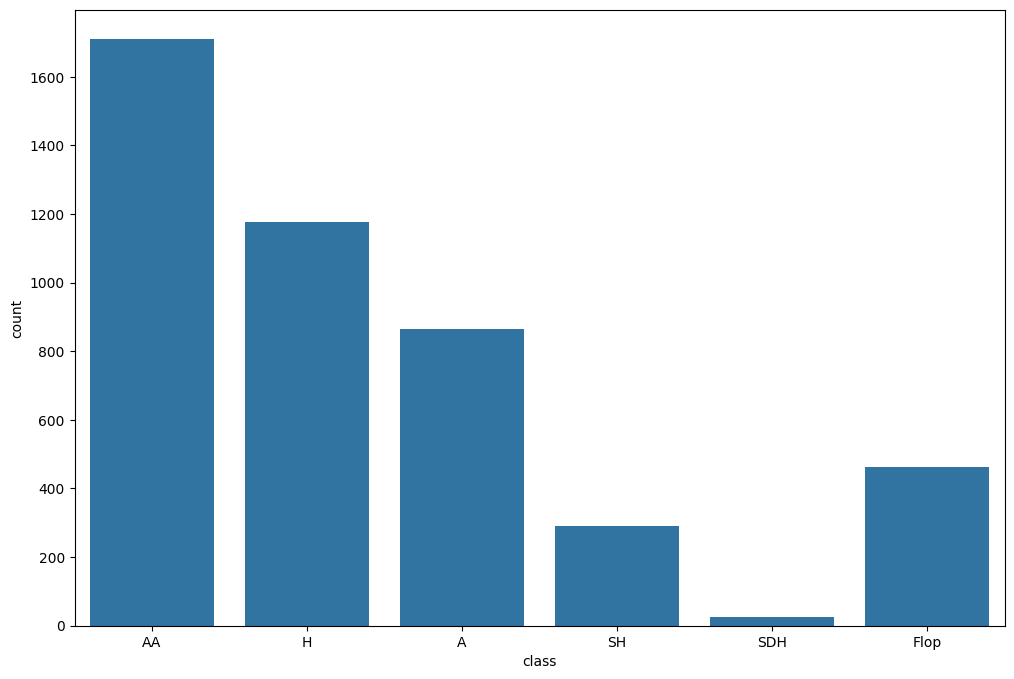

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.countplot(x=df["class"])
plt.show()

In [178]:
df['class'].value_counts()

class
AA      1710
H       1178
A        866
Flop     464
SH       290
SDH       24
Name: count, dtype: int64

CNN

In [179]:
import warnings
warnings.filterwarnings("ignore")

In [180]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import unique
import pandas as pd

df_ratings = pd.read_csv("movie_metadata.csv")

original_title = df_ratings['movie_title']
org_title = []
# Removing white space
for tile in original_title:
    org_title.append(tile.strip())

df_ratings['movie_title'] = org_title

ratings = df_ratings["imdb_score"]
rating_list = []
for rating in ratings:
    if rating >= 0 and rating <= 4.9:
        rating_list.append(0)
    elif rating >= 5 and rating <= 5.9:
        rating_list.append(1)
    elif rating >= 6 and rating <= 6.9:
        rating_list.append(2)
    elif rating >= 7 and rating <= 7.9:
        rating_list.append(3)
    elif rating >= 8 and rating <= 8.9:
        rating_list.append(4)
    else:
        rating_list.append(5)


df_ratings['hit_class'] = rating_list

df = df_ratings[['num_voted_users', 'imdb_score', 'hit_class']]

x = df.drop('hit_class', axis=1)
y = df['hit_class']



x = x.values.reshape(x.shape[0], x.shape[1], 1)

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.30)
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(2,1)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(6, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy',
     optimizer = "adam",
              metrics = ['accuracy'])
model.summary()
model.fit(xtrain, ytrain, batch_size=16,epochs=100,verbose=0)
acc = model.evaluate(xtrain, ytrain)
print("Loss:", acc[0], " Accuracy:", acc[1])
pred = model.predict(xtest)
pred_y = pred.argmax(axis=-1)
print(pred_y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             192       
                                                                 
 dense_4 (Dense)             (None, 1, 16)             1040      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 16)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1334 (5.21 KB)
Trainable params: 1334 (5.21 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [181]:
model.save('CNN_model.h5')

rf

In [182]:
import pandas as pd
import numpy as np
import nltk
import json
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.datasets import load_iris
from numpy import unique

from sklearn.ensemble import RandomForestClassifier

df_ratings=pd.read_csv("movie_metadata.csv")

ratings=df_ratings["imdb_score"]
rating_list=[]
for rating in ratings:
        if rating>=0 and rating<=4.9:
                rating_list.append(0)
        elif rating >= 5 and rating <= 5.9:
                rating_list.append(1)
        elif rating >= 6 and rating <= 6.9:
                rating_list.append(2)
        elif rating >= 7 and rating <= 7.9:
                rating_list.append(3)
        elif rating >= 8 and rating <= 8.9:
                rating_list.append(4)
        else:
                rating_list.append(5)
print(rating_list[1:10])

df_ratings['hit_class']=rating_list

print(df_ratings[['num_voted_users','imdb_score','hit_class']][:5])
df=df_ratings[['num_voted_users','imdb_score','hit_class']]


x= df.drop('hit_class',axis=1)
y = df['hit_class']




print(x.shape)
print(x.shape)

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)

rf=RandomForestClassifier()
rf.fit(xtrain,ytrain)



predict=rf.predict(xtest)

print(accuracy_score(predict,ytest))
print(rating_list[1:10])

[3, 2, 4, 3, 2, 2, 3, 3, 3]
   num_voted_users  imdb_score  hit_class
0           886204         7.9          3
1           471220         7.1          3
2           275868         6.8          2
3          1144337         8.5          4
4                8         7.1          3
(5043, 2)
(5043, 2)
1.0
[3, 2, 4, 3, 2, 2, 3, 3, 3]


In [183]:
import joblib
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [184]:
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

movie poplarity

In [185]:
import pandas as pd
import numpy as np
import nltk
import json
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D,Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import unique

def movie_hit_prediciton(movie_name):
        df_ratings = pd.read_csv("movie_metadata.csv")


        original_title = df_ratings['movie_title']
        org_title = []
        #Removing white space
        for tile in original_title:
                org_title.append(tile.strip())

        df_ratings['movie_title'] = org_title


        ratings = df_ratings["imdb_score"]
        rating_list = []
        for rating in ratings:
                if rating >= 0 and rating <= 4.9:
                        rating_list.append(0)
                elif rating >= 5 and rating <= 5.9:
                        rating_list.append(1)
                elif rating >= 6 and rating <= 6.9:
                        rating_list.append(2)
                elif rating >= 7 and rating <= 7.9:
                        rating_list.append(3)
                elif rating >= 8 and rating <= 8.9:
                        rating_list.append(4)
                else:
                        rating_list.append(5)
        #print(rating_list[1:10])

        df_ratings['hit_class'] = rating_list
        return_sequences=True
        # model=Sequential()
        model.add(Flatten())
        model.add(Dense(6, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer="adam",
                      metrics=['accuracy'])
        model.summary()
        model.fit(xtrain, ytrain, batch_size=16, epochs=100, verbose=0)

        from sklearn.ensemble import RandomForestClassifier
        rf = RandomForestClassifier()
        rf.fit(xtrain, ytrain)
        return pred_y[0]


mn='Avatar'
print(movie_hit_prediciton(mn))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             192       
                                                                 
 dense_4 (Dense)             (None, 1, 16)             1040      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 16)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
 flatten_4 (Flatten)         (None, 6)                 0         
                                                      

2


In [186]:
import pandas as pd
import numpy as np
import nltk
import json
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D,Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.neural_network import MLPClassifier

def audience_prediciton(movie_name):
        df_ratings = pd.read_csv("movie_metadata.csv")
        original_title = df_ratings['movie_title']
        org_title = []
        #Removing white space
        for tile in original_title:
                org_title.append(tile.strip())

        df_ratings['movie_title'] = org_title


        ratings = df_ratings["imdb_score"]
        rating_list = []
        for rating in ratings:
                if rating >= 0 and rating <= 5.9:
                        rating_list.append(1)
                elif rating >= 6 and rating <= 6.9:
                        rating_list.append(2)
                elif rating >= 7 and rating <= 7.9:
                        rating_list.append(3)
                else:
                        rating_list.append(4)

        df_ratings['audience_class'] = rating_list

        df = df_ratings[['num_voted_users', 'imdb_score', 'audience_class']]

        x = df.drop('audience_class', axis=1)
        y = df['audience_class']
        # print(y)
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15)

        mlp = MLPClassifier()
        mlp.fit(xtrain, ytrain)
        x_test=[]
        no_votes=0
        score_val=0
        df_rv2 = df_ratings.loc[df_ratings['movie_title']==movie_name, ['num_voted_users', 'imdb_score']]
        for votes in df_rv2["num_voted_users"]:
                no_votes = votes
        for score in df_rv2["imdb_score"]:
                #print(score)
                score_val = score

        predict_result = mlp.predict([[no_votes,score_val]])
        print(predict_result)
        return predict_result

# mn='Avatar'
# print(audience_prediciton(mn))

In [187]:
def target_audience(movie_name):
  results=[]
  print(movie_name)
  ta_prediction=audience_prediciton(movie_name)
  print("pre=",ta_prediction)
  predict_res=ta_prediction[0]
  if predict_res==1:
    result="Junior"
  elif predict_res==2:
    result="Teenage"
  elif predict_res == 3:
    result = "Mid-age"
  else:
    result = "Senior"
  print('Target audience for the movie',movie_name,'is',result)

In [188]:
target_audience('The Princess Diaries')

The Princess Diaries
[1]
pre= [1]
Target audience for the movie The Princess Diaries is Junior


In [189]:
target_audience('Krull')

Krull
[2]
pre= [2]
Target audience for the movie Krull is Teenage


In [190]:
import pandas as pd
import plotly.figure_factory as ff
data=pd.read_csv('movie_metadata.csv')

In [191]:
data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [192]:
data=data[['movie_title','genres','imdb_score']]
data.columns

Index(['movie_title', 'genres', 'imdb_score'], dtype='object')

In [193]:
score=list((data['imdb_score']))

In [194]:
len(score)
print(score)

[7.9, 7.1, 6.8, 8.5, 7.1, 6.6, 6.2, 7.8, 7.5, 7.5, 6.9, 6.1, 6.7, 7.3, 6.5, 7.2, 6.6, 8.1, 6.7, 6.8, 7.5, 7.0, 6.7, 7.9, 6.1, 7.2, 7.7, 8.2, 5.9, 7.0, 7.8, 7.3, 7.2, 6.5, 6.8, 7.3, 6.0, 5.7, 6.4, 6.7, 6.8, 6.3, 5.6, 8.3, 6.6, 7.2, 7.0, 8.0, 7.8, 6.3, 7.3, 6.6, 7.0, 6.3, 6.2, 6.8, 7.2, 7.5, 8.4, 6.2, 5.8, 6.8, 5.4, 6.6, 6.9, 7.3, 9.0, 8.3, 6.5, 7.9, 7.5, 4.8, 5.2, 6.9, 5.4, 7.9, 6.1, 5.8, 8.3, 7.8, 7.0, 6.1, 7.0, 7.6, 4.5, 6.3, 7.8, 6.4, 6.5, 7.9, 7.8, 6.6, 5.5, 8.2, 6.4, 8.1, 8.6, 8.8, 8.2, 7.9, 6.7, 7.8, 7.8, 6.6, 6.1, 5.6, 6.4, 6.1, 7.3, 6.6, 6.3, 6.1, 7.1, 5.5, 7.5, 7.6, 6.4, 7.2, 6.7, 8.0, 8.3, 6.7, 5.9, 6.7, 6.7, 7.6, 7.2, 7.1, 8.1, 6.7, 7.0, 6.9, 5.1, 5.8, 6.2, 7.4, 5.8, 6.6, 6.2, 7.3, 4.2, 6.9, 6.4, 5.4, 6.7, 5.8, 6.9, 7.2, 6.9, 6.1, 5.5, 6.6, 6.1, 6.3, 7.2, 7.4, 7.3, 6.1, 7.7, 6.1, 8.0, 7.3, 7.9, 5.5, 5.0, 7.7, 6.6, 5.7, 5.8, 6.0, 6.4, 6.9, 6.4, 7.4, 5.5, 5.9, 6.8, 7.5, 6.8, 8.1, 6.5, 7.2, 6.7, 8.1, 7.6, 7.4, 7.6, 5.5, 6.7, 6.5, 6.6, 6.7, 6.4, 5.8, 7.4, 7.8, 6.6, 4.9, 6.5, 7.5,

In [195]:

def class_of_movie(score):
  rating_list=[]
  for rating in score:
    if rating >= 0 and rating <= 4.9:
      rating_list.append('F')
    elif rating >= 5 and rating <= 5.9:
      rating_list.append('A')
    elif rating >= 6 and rating <= 6.9:
      rating_list.append('AA')
    elif rating >= 7 and rating <= 7.9:
      rating_list.append('H')
    elif rating >= 8 and rating <= 8.9:
      rating_list.append('SH')
    else:
      rating_list.append('SDH')
  return rating_list
data['class']=class_of_movie(score)
data.columns

Index(['movie_title', 'genres', 'imdb_score', 'class'], dtype='object')

In [201]:
data=data.head(10)
data

,movie_title,genres,imdb_score,class
0,Avatar,Action|Adventure|Fantasy|Sci-Fi,7.9,H
1,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,7.1,H
2,Spectre,Action|Adventure|Thriller,6.8,AA
3,The Dark Knight Rises,Action|Thriller,8.5,SH
4,Star Wars: Episode VII - The Force Awakens ...,Documentary,7.1,H
5,John Carter,Action|Adventure|Sci-Fi,6.6,AA
6,Spider-Man 3,Action|Adventure|Romance,6.2,AA
7,Tangled,Adventure|Animation|Comedy|Family|Fantasy|Musi...,7.8,H
8,Avengers: Age of Ultron,Action|Adventure|Sci-Fi,7.5,H
9,Harry Potter and the Half-Blood Prince,Adventure|Family|Fantasy|Mystery,7.5,H


In [203]:
import pandas as pd
import numpy as np
import nltk
import json
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D,Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.neural_network import MLPClassifier

def audience_prediciton(movie_name):
        df_ratings = pd.read_csv("movie_metadata.csv")
        original_title = df_ratings['movie_title']
        org_title = []
        #Removing white space
        for tile in original_title:
                org_title.append(tile.strip())

        df_ratings['movie_title'] = org_title


        ratings = df_ratings["imdb_score"]
        rating_list = []
        for rating in ratings:
                if rating >= 0 and rating <= 5.9:
                        rating_list.append(1)
                elif rating >= 6 and rating <= 6.9:
                        rating_list.append(2)
                elif rating >= 7 and rating <= 7.9:
                        rating_list.append(3)
                else:
                        rating_list.append(4)

        df_ratings['audience_class'] = rating_list

        df = df_ratings[['num_voted_users', 'imdb_score', 'audience_class']]

        x = df.drop('audience_class', axis=1)
        y = df['audience_class']
        # print(y)
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15)

        mlp = MLPClassifier()
        mlp.fit(xtrain, ytrain)
        x_test=[]
        no_votes=0
        score_val=0
        df_rv2 = df_ratings.loc[df_ratings['movie_title']==movie_name, ['num_voted_users', 'imdb_score']]
        for votes in df_rv2["num_voted_users"]:
                no_votes = votes
        for score in df_rv2["imdb_score"]:
                #print(score)
                score_val = score

        predict_result = mlp.predict([[no_votes,score_val]])
        # print(predict_result)
        return predict_result

mn='Avatar'
print(audience_prediciton(mn))

[1]


In [204]:
def target_audience(movie_name):
  results=[]
  # print(movie_name)
  ta_prediction=audience_prediciton(movie_name)
  # print("pre=",ta_prediction[0])
  predict_res=ta_prediction[0]
  if predict_res==1:
    result="Junior"
  elif predict_res==2:
    result="Teenage"
  elif predict_res == 3:
    result = "Mid-age"
  else:
    result = "Senior"
  print('Target audience for the movie',movie_name,'is',result)
  return result


In [206]:
movies=list(data['movie_title'])
audience_list=[]
for movie in movies:
  audience=target_audience(movie)
  audience_list.append(audience)
data['target_audience']=audience_list
print(data.columns)
print(data.head())

Target audience for the movie Avatar  is Junior
Target audience for the movie Pirates of the Caribbean: At World's End  is Junior
Target audience for the movie Spectre  is Teenage
Target audience for the movie The Dark Knight Rises  is Junior
Target audience for the movie Star Wars: Episode VII - The Force Awakens              is Junior
Target audience for the movie John Carter  is Junior
Target audience for the movie Spider-Man 3  is Junior
Target audience for the movie Tangled  is Junior
Target audience for the movie Avengers: Age of Ultron  is Junior
Target audience for the movie Harry Potter and the Half-Blood Prince  is Teenage
Index(['movie_title', 'genres', 'imdb_score', 'class', 'target_audience'], dtype='object')
                                         movie_title  \
0                                            Avatar    
1          Pirates of the Caribbean: At World's End    
2                                           Spectre    
3                             The Dark Knigh

In [207]:
def recommend_movies(df):
    colorscale = [[0, '#fad2e1'], [.5, '#fde2e4'], [1, '#fff1e6']]
    fig = ff.create_table(data, colorscale=colorscale, height_constant=70)
    return fig

In [208]:
recommend_movies(data)